In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"D:\DP\Sachin Sir\Train\Train1"
valid_dir=r"D:\DP\Sachin Sir\Train\Test1"
train_folder=listdir(train_dir)
valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
callbacks = MyCustomCallback()

In [6]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Forged ...
processing Original ...
[INFO] Image loading completed


In [7]:
print(len(train_image_label))

16000


In [8]:
valid_image_list, valid_image_label= [], []
for disease_folder in valid_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{valid_dir}/{disease_folder}")

    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]: 
        image_directory = f"{valid_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
            valid_image_list.append(convert_image_to_array(image_directory))
            valid_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Forged ...
processing Original ...
[INFO] Image loading completed


In [9]:
print(len(valid_image_label))

4000


In [10]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_ped.pk2', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(n_classes)

2


In [12]:
np_train_image_list = np.array(train_image_list, dtype=np.float16) / 255.0
np_valid_image_list = np.array(valid_image_list, dtype=np.float16) / 255.0

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [29]:

# coding: utf8
from keras import layers
from keras import models


#
# image dimensions
#

img_height = 224
img_width = 224
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_555 (Conv2D)             (None, 112, 112, 64) 4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 112, 112, 64) 256         conv2d_555[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_50 (LeakyReLU)      (None, 112, 112, 64) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

conv2d_985 (Conv2D)             (None, 14, 14, 8)    584         lambda_914[0][0]                 
__________________________________________________________________________________________________
conv2d_986 (Conv2D)             (None, 14, 14, 8)    584         lambda_915[0][0]                 
__________________________________________________________________________________________________
conv2d_987 (Conv2D)             (None, 14, 14, 8)    584         lambda_916[0][0]                 
__________________________________________________________________________________________________
conv2d_988 (Conv2D)             (None, 14, 14, 8)    584         lambda_917[0][0]                 
__________________________________________________________________________________________________
conv2d_989 (Conv2D)             (None, 14, 14, 8)    584         lambda_918[0][0]                 
__________________________________________________________________________________________________
conv2d_990

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
#model.add(Dense(4096))
#model.add(Activation('relu'))
# Add Dropout
#model.add(Dropout(0.4))

# 3rd Fully Connected Layer
#model.add(Dense(1000))
#model.add(Activation('relu'))
# Add Dropout
#model.add(Dropout(0.4))

# Output Layer
model.add(Dense(1))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_550 (Conv2D)          (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_551 (Conv2D)          (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_552 (Conv2D)          (None, 6, 6, 384)        

In [30]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")


[INFO] training network...


In [31]:
history=model.fit(np_train_image_list,bin_train_image_labels,
                  validation_data=(np_valid_image_list, bin_valid_image_labels),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 303s 19ms/step - loss: 0.6318 - accuracy: 0.6984 - val_loss: 1.1725 - val_accuracy: 0.5645
Epoch 2/30
16000/16000 [==============================] - 272s 17ms/step - loss: 0.3719 - accuracy: 0.8379 - val_loss: 0.5124 - val_accuracy: 0.7995
Epoch 3/30
16000/16000 [==============================] - 270s 17ms/step - loss: 0.2510 - accuracy: 0.9047 - val_loss: 0.3544 - val_accuracy: 0.8665
Epoch 4/30
16000/16000 [==============================] - 273s 17ms/step - loss: 0.2002 - accuracy: 0.9286 - val_loss: 0.5636 - val_accuracy: 0.8265
Epoch 5/30
16000/16000 [==============================] - 273s 17ms/step - loss: 0.1757 - accuracy: 0.9417 - val_loss: 0.1974 - val_accuracy: 0.9335
Epoch 6/30
16000/16000 [==============================] - 273s 17ms/step - loss: 0.1535 - accuracy: 0.9499 - val_loss: 0.3784 - val_accuracy: 0.8485
Epoch 7/30
16000/16000 [==============================] -

In [32]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np_valid_image_list, bin_valid_image_labels)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4000/4000 [==============================] - 16s 4ms/step
Test Accuracy: 96.5749979019165


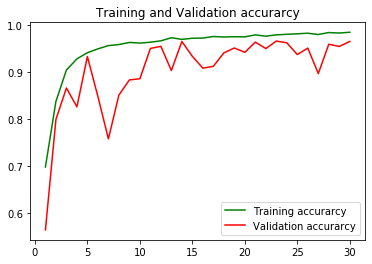

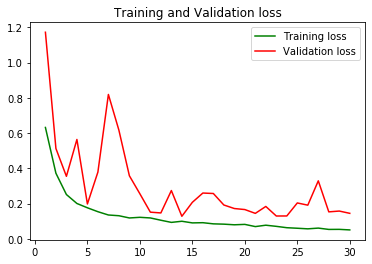

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [48]:
ycalculated = model.predict(np_valid_image_list)

In [49]:
yhat_classes =np.argmax(ycalculated,axis=1)

In [50]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)


In [51]:
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
#import seaborn as sns
#y_pred=model.predict_classes(np_valid_image_list)
#con_mat = tf.math.confusion_matrix(labels=y_true, predictions=ycalculated).numpy()
#matrix = confusion_matrix(rounded_labels,yhat_classes)
#y_pred=model.predict(np.array(val_image_list))
#yhat_classes = ["honda", "chevrolet", "honda", "toyota", "toyota", "chevrolet"]
#rounded_labels = ["honda", "chevrolet", "honda", "toyota", "toyota", "honda"]
cm =confusion_matrix(bin_valid_image_labels,yhat_classes)  

#matrix =confusion_matrix(bin_val_image_labels.argmax(axis=1), ycalculated)
#print(ma

In [38]:
import numpy as np
rounded_labels=np.argmax(bin_valid_image_labels,axis=1)


In [52]:
accuracy = accuracy_score(bin_valid_image_labels,yhat_classes) 
print('Accuracy: %f' % accuracy)

Accuracy: 0.965750


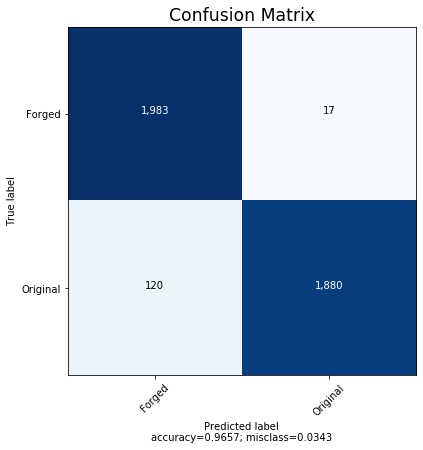

In [54]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm, 
                      normalize = False,
                      target_names = ['Forged','Original'],
                      title        = "Confusion Matrix")

In [55]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['Forged','Original'] 
print(classification_report(bin_valid_image_labels, yhat_classes, target_names=target_names))

              precision    recall  f1-score   support

      Forged       0.94      0.99      0.97      2000
    Original       0.99      0.94      0.96      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



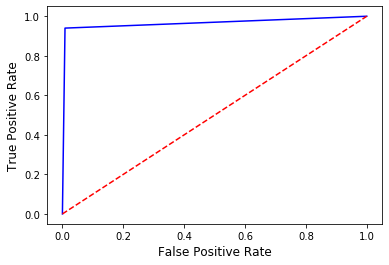

In [59]:
fpr, tpr, threshold = roc_curve(bin_valid_image_labels,yhat_classes) 

plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.show()

In [60]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
#cm = confusion_matrix(testY, np.argmax(predY, axis = -1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[1983   17]
 [ 120 1880]]
sensitivity: 0.9915
specificity: 0.9400


In [47]:
model.save('testdp.h5')

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
